## Problem 1 (10 pts)

### `[Question 1.1]`:

- `(2 pts)` Prove that gradients, computed in two sequential points, generated by the steepest gradient descent, are orthogonal


In [36]:
from __future__ import annotations

import numpy as np
from typing import Tuple

def make_spd_matrix(n: int, *, seed: int = 0) -> np.ndarray:
    """
    Construct a symmetric positive definite matrix Q = A^T A + mu I.
    """
    rng: np.random.Generator = np.random.default_rng(seed)
    A: np.ndarray = rng.standard_normal(size=(n, n))
    mu: float = 0.5
    Q: np.ndarray = A.T @ A + mu * np.eye(n)
    return Q


def quadratic_minimizer(Q: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    x* = Q^{-1} b (solve linear system, do NOT explicitly invert).
    """
    x_star: np.ndarray = np.linalg.solve(Q, b)
    return x_star


### ***`1.1 Orthogonality of successive gradients (steepest descent + exact line search):`***

## **Goal**:

We need to prove that for two sequential points  $x^k$ and  $x^{k+1}$ generated by the steepest gradient descent, the gradients $\nabla f(x^k)$ and $\nabla f(x^{k+1})$ are orthogonal, i.e.,

$$
\nabla f(x^k)^{\top} \nabla f(x^{k+1}) = 0.
$$


1. Steepest descent uses:
$$
x^{k+1} = x^k - \alpha_k . \nabla f(x^k),
$$
where $\alpha_k$ is the step size chose by exact line search:
$$
\alpha_k = \arg \min_{\alpha \geq 0} f(x^k - \alpha . \nabla f(x^k)).
$$

---

2. Define the function (1D function):
$$
\phi(\alpha) = f(x^k - \alpha . g_k), \quad g_k := \nabla f(x^k)
$$

---

3. At the minimizer $\alpha_k$, the derivative of $\phi(\alpha_k)$ is zero, hence $\phi'(\alpha_k) = 0$. Using the chain rule, we have:
$$
d\phi(\alpha)/d\alpha = \phi'(\alpha) = \nabla f(x^k - \alpha . g_k)^{\top} (- g_k).
$$
$$
\phi'(\alpha) = - g_k^{\top} \nabla f(x^k - \alpha . g_k), \quad x^{k+1} = x^k - \alpha_k . g_k
$$

$$
\phi'(\alpha) = - g_k^{\top} \nabla f(x^{k+1})
$$

---

4. Thus, at $\alpha = \alpha_k$, we have:
$$
\phi'(\alpha_k) = - g_k^{\top} \nabla f(x^{k+1}) = 0
$$

Hence,
$$
g_k^{\top} \nabla f(x^{k+1}) = 0, \quad g_k^{\top} = \nabla f(x^k)^{\top}
$$

$$
\nabla f(x^k)^{\top} . \nabla f(x^{k+1}) = 0
$$

This completes the proof that the gradients at two sequential points generated by the steepest gradient descent are orthogonal. $□$

---

In [37]:
def steepest_descent_quadratic_step(x: np.ndarray, Q: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, float, np.ndarray]:
    """
    One steepest-descent step for f(x)=0.5 x^T Q x - b^T x with exact line search.

    Returns:
        x_next, alpha, grad_at_x
    """
    grad: np.ndarray = Q @ x - b
    num: float = float(grad.T @ grad)
    den: float = float(grad.T @ (Q @ grad))
    alpha: float = num / den
    x_next: np.ndarray = x - alpha * grad
    return x_next, alpha, grad

def run_test_orthogonality(*, n: int = 8, seed: int = 1, epslon: float = 1e-6) -> None:
    """
    Test: For a quadratic with exact line search,
    gradients at two successive iterates are orthogonal: g1^T g0 ~ 0.
    """
    rng: np.random.Generator = np.random.default_rng(seed)

    Q: np.ndarray = make_spd_matrix(n=n, seed=seed)
    b: np.ndarray = rng.standard_normal(size=n)

    x0: np.ndarray = rng.standard_normal(size=n)

    x1, alpha0, g0 = steepest_descent_quadratic_step(x=x0, Q=Q, b=b)
    g1: np.ndarray = Q @ x1 - b
    dot: float = float(g1.T @ g0)

    ans = abs(dot) / (np.linalg.norm(g1) * np.linalg.norm(g0))
    check_answer: bool = ans < epslon
    
    print("=======================================")
    print("   Orthogonality test (quadratic)      ")
    print("=======================================")
    print(f"- alpha0  = {alpha0:.6e}")
    print(f"- g1^T g0 = {dot:.6e}")
    print(f"- |g1^T g0| / (||g1|| ||g0||) = {ans:.6e}\n")
    print(f"Expected: close to 0: {check_answer}")
    print("=======================================")

run_test_orthogonality(n=10, seed=10)


   Orthogonality test (quadratic)      
- alpha0  = 4.469408e-02
- g1^T g0 = 6.394885e-13
- |g1^T g0| / (||g1|| ||g0||) = 8.109017e-16

Expected: close to 0: True


### `[Question 1.2]`:

- `(5 pts)` Prove that if the objective function is $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, step size is chosen according to the steepest descent rule and $x^0 - x^*$ is parallel to the eigenvector of the matrix $Q$, then gradient descent converges after one iteration.


### ***`1.2 One-step convergence for a quadratic if the initial error is an eigenvector direction:`***


* **Objective Function**:
$$
f(x) = \frac{1}{2} . x^{\top} . Q . x - b^{\top} x, \quad Q \in \mathbb{S}^n_{++}
$$

1. Applying nabla operator to f(x):
$$
\nabla f(x) = Q . x - b
$$

---

2. The minimizer $x^*$ satisfies:
$$
\nabla f(x^*) = Q . x^* - b = 0 \implies Q . x^* = b \implies x^* = Q^{-1} . b
$$

---

3. Therefore:
- Let the error be $e_0 := x_0 - x^* \implies x_0 = e_0 + x^*$;
- We were given that $Q.e_0 = \lambda . e_0, \quad \lambda \gt 0 $ (since $x_0 - x^*$ was defined as a parallel to the eigenvector of the matrix $Q$);<br>
Then:

$$
\nabla f(x_0) = Q . x_0 - b \\
\nabla f(x_0) = Q . (e_0 + x^*) - b \\
\nabla f(x_0) = Q . e_0 + (Q . x^* - b) \\
\nabla f(x_0) = Q . e_0 + 0 \\
\nabla f(x_0) = Q . e_0 \\
Q . e_0 = \lambda . e_0
$$

---

4. The steepest descent step is $x_1 = x_0 - \alpha_0 . \nabla f(x_0)$, where $\alpha_0$ is chosen by exact line search. For convergence in one step, we need $x_1 = x^*$, which means:
$$
x^* = x_0 - \alpha_0 . \nabla f(x_0) \\
x^* = x_0 - \alpha_0 . \lambda . e_0 \\
x_0 - x^* = \alpha_0 . \lambda . e_0 \\
e_0 = \frac{(x_0 - x^*)}{\alpha_0 . \lambda}
$$

It holds if $\alpha_0 = \frac{1}{\lambda}$

---

5. Steepest descent uses:
$$
x_{k+1} = x_k - \alpha_k . \nabla f(x_k)\\
\alpha_k \in \arg \min_{\alpha \geq 0} f(x_k - \alpha . \nabla f(x_k))
$$

---

6. Define the function (1D function):
$$
\phi(\alpha) = f(x_k - \alpha . g_k), \quad g_k := \nabla f(x_k) \\
f(x) = \frac{1}{2} . x^{\top} . Q . x - b^{\top} x
$$

Then,
$$
\phi(\alpha) = \frac{1}{2} . (x_k - \alpha . g_k)^{\top} . Q . (x_k - \alpha . g_k) - b^{\top} (x_k - \alpha . g_k)\\
\phi(\alpha) = \frac{1}{2} . (x_k^{\top} . Q . x_k - 2 \alpha . g_k^{\top} . Q . x_k + \alpha^2 . g_k^{\top} . Q . g_k) - b^{\top} x_k + \alpha . b^{\top} g_k\\
\phi(\alpha) = f(x_k) - \alpha . g_k^{\top} . (Q . x_k - b) + \frac{1}{2} . \alpha^2 . g_k^{\top} . Q . g_k \\
$$

Taking the derivative of $\phi(\alpha)$ with respect to $\alpha$:
$$
\phi'(\alpha) = - g_k^{\top} . (Q . x_k - b) + \alpha . g_k^{\top} . Q . g_k
$$

Using $g_k = \nabla f(x_k) = Q . x_k - b$, we have:
$$
\phi'(\alpha) = - g_k^{\top} . g_k + \alpha . g_k^{\top} . Q . g_k
$$

---

7. Setting $\phi'(\alpha) = 0$ to find the minimizer:
$$
- g_k^{\top} . g_k + \alpha_k . g_k^{\top} . Q . g_k = 0 \\
\alpha_k . g_k^{\top} . Q . g_k = g_k^{\top} . g_k \\
\alpha_k = \frac{g_k^{\top} . g_k}{g_k^{\top} .Q . g_k}
$$

---

8. Since we have $\nabla f(x_0) = g_0 = \lambda . e_0$ we can substitute it into the expression for $\alpha_0$:

$$
\alpha_0 = \frac{g_0^{\top} . g_0}{g_0^{\top} .Q . g_0} \\
\alpha_0 = \frac{(\lambda . e_0)^{\top} . (\lambda . e_0)}{(\lambda . e_0)^{\top} . Q . (\lambda . e_0)} \\
\alpha_0 = \frac{\lambda^2 . e_0^{\top} . e_0}{\lambda^2 . e_0^{\top} . Q . e_0} \\
\alpha_0 = \frac{e_0^{\top} . e_0}{e_0^{\top} . Q . e_0} \\
\alpha_0 = \frac{e_0^{\top} . e_0}{e_0^{\top} . (\lambda . e_0)} \\
\alpha_0 = \frac{e_0^{\top} . e_0}{\lambda . (e_0^{\top} . e_0)} \\
\alpha_0 = \frac{1}{\lambda}
$$

This way we check that the step size $\alpha_0 = \frac{1}{\lambda}$, which guarantees one-step convergence if the initial error is in the direction of an eigenvector of Q.

---

9. Now lets update the error after one step:

$$
e_1 = x_1 - x^* \\
e_0 = x_0 - x^* \\
x_1 = x_0 - \alpha_0 . \nabla f(x_0) \\
e_1 = (x_0 - \alpha_0 . \nabla f(x_0)) - x^* \\
e_1 = (e_0 + x^* - \alpha_0 . \nabla f(x_0)) - x^* \\
e_1 = e_0 - \alpha_0 . \nabla f(x_0) \\
\nabla f(x_0) = Q . e_0
$$

$$
e_1 = e_0 - \alpha_0 . Q . e_0 \\
e_1 = e_0 - \frac{1}{\lambda} . Q . e_0 \\
e_1 = e_0 - \frac{1}{\lambda} . \lambda . e_0 \\ \\
e_1 = e_0 - e_0 \\
e_1 = 0
$$

So $x_1 = x^*$ and we have convergence in one step. $□$

In [38]:
def run_test_one_step_eigenvector(*, n: int = 8, seed: int = 2, epslon: float = 1e-6) -> None:
    """
    Test the theorem (Problem 1.2):
    If e0 = x0 - x* is parallel to an eigenvector of Q, then one step reaches x*.
    """
    rng: np.random.Generator = np.random.default_rng(seed)

    Q: np.ndarray = make_spd_matrix(n=n, seed=seed)
    b: np.ndarray = rng.standard_normal(size=n)
    x_star: np.ndarray = quadratic_minimizer(Q=Q, b=b)

    # eigen-decomposition (Q is symmetric)
    eigvals: np.ndarray
    eigvecs: np.ndarray
    eigvals, eigvecs = np.linalg.eigh(Q)

    # pick an eigenvector direction v
    j: int = int(rng.integers(low=0, high=n))
    v: np.ndarray = eigvecs[:, j]  # unit eigenvector
    lam: float = float(eigvals[j])

    # Building x0 = x* + c v (so e0 = c v)
    c: float = 3.0
    x0: np.ndarray = x_star + c * v

    x1, alpha0, _g0 = steepest_descent_quadratic_step(x=x0, Q=Q, b=b)

    err0: float = float(np.linalg.norm(x0 - x_star))
    err1: float = float(np.linalg.norm(x1 - x_star))

    check_answer: bool = err1 < epslon

    print("=======================================")
    print("   One-step convergence test (eigenvector direction)   ")
    print("=======================================")
    print(f"- picked eigenvalue lambda = {lam:.6e}")
    print(f"- computed alpha0 = {alpha0:.6e} (should be ~ 1/lambda = {1.0/lam:.6e}). Correct: {abs(alpha0 - 1.0/lam) < epslon}")
    print(f"- ||x0 - x*|| = {err0:.6e} AND ||x1 - x*|| = {err1:.6e}")
    print("Expected: ||x1 - x*|| close to 0 :", check_answer)
    print("=======================================")

run_test_one_step_eigenvector(n=10, seed=11)

   One-step convergence test (eigenvector direction)   
- picked eigenvalue lambda = 1.773997e+01
- computed alpha0 = 5.636989e-02 (should be ~ 1/lambda = 5.636989e-02). Correct: True
- ||x0 - x*|| = 3.000000e+00 AND ||x1 - x*|| = 1.183088e-15
Expected: ||x1 - x*|| close to 0 : True


### `[Question 1.3]`:

- Show that for the function $f(x) = x^{\top}x$ the steepest gradient descent converges after one iteration using
    - (1 pts) previous claim
    - (2 pts) direct computations

Using the previous claim:
$$
f(x) = x^{\top}x
$$

The gradient is:
$$
\nabla f(x) = 2x
$$

And we can rewrite the function as:
$$
f(x) = \frac{1}{2} x^{\top} (2I) x - 0^{\top} x
$$

Therefore, $Q = 2I$ and $b = 0$. The eigenvalues of $Q$ are all equal to 2, and the eigenvectors are the standard basis vectors. If we choose an initial point $x^0$ such that $x^0 - x^*$ is parallel to one of the eigenvectors of $Q$, then by the previous claim, the steepest gradient descent will converge after one iteration.

Using direct computations:
1. The minimizer $x^*$ satisfies:
$$
\nabla f(x^*) = 2x^* = 0 \implies x^* = 0
$$

2. Let the initial point be $x^0 = \alpha v$, where $v$ is an eigenvector of $Q$ and $\alpha$ is a scalar. Then, the initial error is:
$$
e_0 = x^0 - x^* = \alpha v - 0 = \alpha v
$$

3. The gradient at the initial point is:
$$
\nabla f(x^0) = 2x^0 = 2\alpha v
$$

4. The steepest descent step is:
$$
x^1 = x^0 - \alpha_0 . \nabla f(x^0)
$$
where $\alpha_0$ is chosen by exact line search.

5. Define the function (1D function):
$$
\phi(\alpha) = f(x^0 - \alpha . g_0), \quad g_0 := \nabla f(x^0)
$$

Then,
$$
\phi(\alpha) = f(x^0 - \alpha . g_0) = (x^0 - \alpha . g_0)^{\top} (x^0 - \alpha . g_0)
$$
$$
\phi(\alpha) = (x^0)^{\top} x^0 - 2\alpha (g_0)^{\top} x^0 + \alpha^2 (g_0)^{\top} g_0
$$

Taking the derivative of $\phi(\alpha)$ with respect to $\alpha$:
$$
\phi'(\alpha) = - 2 (g_0)^{\top} x^0 + 2\alpha (g_0)^{\top} g_0
$$

Setting $\phi'(\alpha) = 0$ to find the minimizer:
$$
- 2 (g_0)^{\top} x^0 + 2\alpha_0 (g_0)^{\top} g_0 = 0 \\
\alpha_0 = \frac{(g_0)^{\top} x^0}{(g_0)^{\top} g_0}
$$

Substituting $g_0 = 2\alpha v$ and $x^0 = \alpha v$:
$$
\alpha_0 = \frac{(2\alpha v)^{\top} (\alpha v)}{(2\alpha v)^{\top} (2\alpha v)} \\
\alpha_0 = \frac{2\alpha^2 (v^{\top} v)}{4\alpha^2 (v^{\top} v)} \\
\alpha_0 = \frac{1}{2}
$$  

6. Now, we can update the point after one step:
$$
x^1 = x^0 - \alpha_0 . \nabla f(x^0) \\
x^1 = \alpha v - \frac{1}{2} . (2\alpha v) \\
x^1 = \alpha v - \alpha v \\
x^1 = 0
$$  

Thus, we have $x^1 = x^*$, and the steepest gradient descent converges after one iteration. $□$

In [39]:
def run_test_fx_equals_xTx(*, n: int = 8, seed: int = 3, epslon: float = 1e-6) -> None:
    """
    Test Problem 1.3 directly for f(x)=x^T x:
    Q=2I, b=0 => alpha0 should be 1/2 and x1 should be 0.
    """
    rng: np.random.Generator = np.random.default_rng(seed)

    Q: np.ndarray = 2.0 * np.eye(n)
    b: np.ndarray = np.zeros(n)

    x0: np.ndarray = rng.standard_normal(size=n)
    x1, alpha0, _g0 = steepest_descent_quadratic_step(x=x0, Q=Q, b=b)

    print("\n=======================================")
    print("   f(x)=x^T x test (Q=2I, b=0)      ")
    print("========================================")
    print(f"- alpha0 = {alpha0:.6e} (should be 0.5)")
    print(f"- ||x1|| = {np.linalg.norm(x1):.6e} (should be 0)")
    print("Expected: x1 is (numerically) the zero vector. Correct:", np.linalg.norm(x1) < epslon)
    print("=======================================")

run_test_fx_equals_xTx(n=10, seed=12)



   f(x)=x^T x test (Q=2I, b=0)      
- alpha0 = 5.000000e-01 (should be 0.5)
- ||x1|| = 0.000000e+00 (should be 0)
Expected: x1 is (numerically) the zero vector. Correct: True


## Problem 2 (12 pts)



Consider the signal denoising problem and smooth approximation of the total-variation regularizer.
Let $x_{cor}$ be a corrupted signal that you should recover.
To perform such recovering you can use total variation regulaizer $TV(x) = \sum_{i=0}^{n-1} |x_{i+1} - x_i|$.
However, it is non-smooth and therefore direct usage of the first order method is prohibitive.
To address this issue one can replace the original total variationa regularizer with its smooth approximation.


$$ ATV(x) = \sum_{i=0}^{n-1} \left(\sqrt{\varepsilon^2 + (x_{i+1} - x_i)^2} - \varepsilon\right),$$

where $\varepsilon > 0$ is a hyper-parameter controling the accuracy of approximation.

Thus, the final denoising problem is the following

$$ \min_x \|x - x_{cor}\|_2^2 + \lambda ATV(x), $$

where $\lambda > 0$ is a hyperparameter that controls the smoothness of the resulting signal $x^*$.
Use the corrupted signal and hyperparameters from the cell below. Choose appropriate value for $\lambda$, it is typically of the order 10-100.




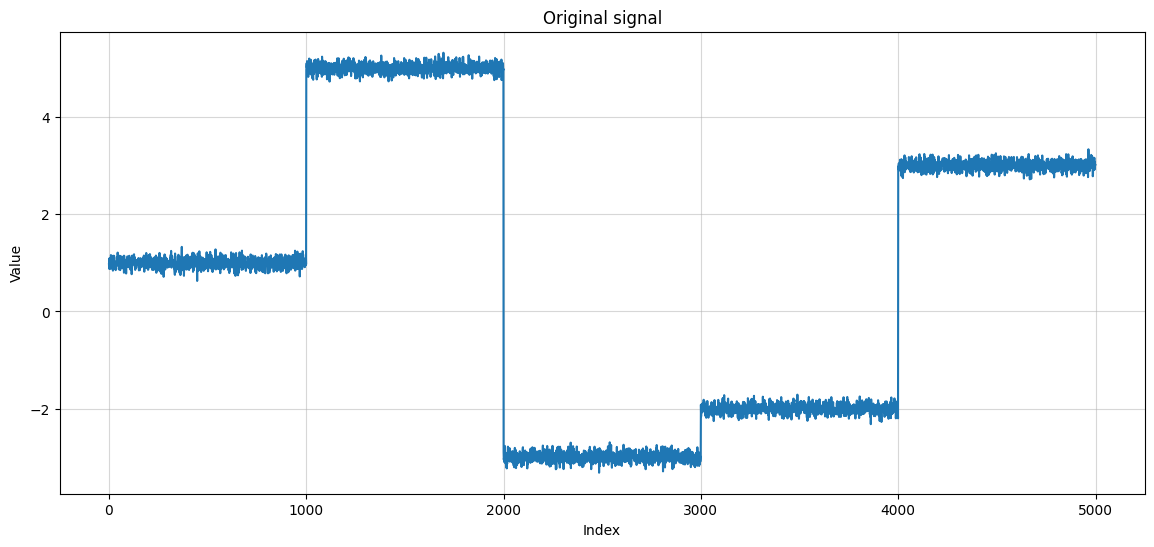

In [40]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000
EPSILON = 0.001

xcor = np.hstack([
     np.ones(1000) + 0.1 * np.random.randn(1000), 
     5 * np.ones(1000) + 0.1 *np.random.randn(1000),
    -3*np.ones(1000) + 0.1 *np.random.randn(1000), 
    -2 * np.ones(1000) + 0.1 *np.random.randn(1000),
     3 * np.ones(1000) + 0.1 *np.random.randn(1000),
])

plt.figure(figsize=(14, 6))
plt.title("Original signal")
plt.xlabel("Index"); plt.ylabel("Value")
plt.grid(alpha=0.5); plt.plot(xcor); plt.show()


### `[Question 2.1]`:
- (5 pts) Compare convergence of gradient descent, heavy-ball method and fast gradient method to solve this problem with a number of constant step sizes $\alpha = \{1, 10^{-1}, 10^{-2}, 10^{-3}, 10^{-4} \}$. Make a conclusion about the methods performances and their dependence on step size value.


### `[Question 2.2]`:

- (5 pts) Check numerically how the value of $\varepsilon$ affects the resulting signal quality and the convergence of the aforementioned methods. Make the necessary plots that confirm your conclusions. Explain the observed behaviour.


### `[Question 2.3]`:

- (2 pts) Visualize the resulting signals from all three considered optimizers (choose the best result for every optimizer) on the one frame with the original corrupted signal. Do you observe some differences in the solutions?
